# Reflection with LangChain (Tweet Generator)

## Generate

In [1]:
%pip install -U -q openai langchain langchain-openai langchain-community langgraph

Note: you may need to restart the kernel to use updated packages.


In [2]:
from dotenv import load_dotenv, find_dotenv
load_dotenv(find_dotenv(), override=True)

True

In [3]:
from langchain_core.messages import AIMessage, HumanMessage, BaseMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_openai import ChatOpenAI

In [10]:
# Creating a chat prompt template
generation_prompt = ChatPromptTemplate.from_messages([
  ('system', 
   '''You are a Tweeter expert assigned to craft outstanding tweets.
   Generate the most engaging and impactful tweet possible based on the user's request.
   If the user provides feedback, refine and enhance your previous attempts accordingly for maximum engagement.'''),
  MessagesPlaceholder(variable_name='messages'),
])

llm = ChatOpenAI(model_name='gpt-4o-mini', temperature=0.7)

# using LCEL to create the generate_chain
generate_chain =  generation_prompt | llm

In [7]:
generate_chain

ChatPromptTemplate(input_variables=['messages'], input_types={'messages': list[typing.Annotated[typing.Union[typing.Annotated[langchain_core.messages.ai.AIMessage, Tag(tag='ai')], typing.Annotated[langchain_core.messages.human.HumanMessage, Tag(tag='human')], typing.Annotated[langchain_core.messages.chat.ChatMessage, Tag(tag='chat')], typing.Annotated[langchain_core.messages.system.SystemMessage, Tag(tag='system')], typing.Annotated[langchain_core.messages.function.FunctionMessage, Tag(tag='function')], typing.Annotated[langchain_core.messages.tool.ToolMessage, Tag(tag='tool')], typing.Annotated[langchain_core.messages.ai.AIMessageChunk, Tag(tag='AIMessageChunk')], typing.Annotated[langchain_core.messages.human.HumanMessageChunk, Tag(tag='HumanMessageChunk')], typing.Annotated[langchain_core.messages.chat.ChatMessageChunk, Tag(tag='ChatMessageChunk')], typing.Annotated[langchain_core.messages.system.SystemMessageChunk, Tag(tag='SystemMessageChunk')], typing.Annotated[langchain_core.mes

In [11]:
tweet = ''
request = HumanMessage(
  content="FIFA World Cup 26"
)

for chunk in generate_chain.stream(
  {'messages': [request]}
):
  print(chunk.content, end='')
  tweet += chunk.content

🏆🌍 The countdown to #FIFAWorldCup26 has officially begun! 🎉✨ Get ready for football fever as the world's best teams clash in North America! Who are you rooting for? 🇺🇸🇨🇦🇲🇽⚽️ Let the games begin! #WorldCup #FootballFever #SoccerLove

## Reflect and Repeat

In [13]:
reflection_prompt = ChatPromptTemplate.from_messages([
  ('system', 
   '''You are a Tweeter influencer known for your engaging content and sharp insights.
   Review and critique the user's tweet.
   Provide constructive feedback, focusing on enhancing its depth, style and overall impact.
   Offer specific suggestions to make the tweet more compelling and engaging for their audience.'''),
  MessagesPlaceholder(variable_name='messages'),
])

reflect_chain =  reflection_prompt | llm

In [14]:
reflection = ''
for chunk in reflect_chain.stream(
  {'messages': [request, HumanMessage(content=tweet)]}
):
  print(chunk.content, end='')
  reflection += chunk.content

This tweet does a great job of capturing excitement for the upcoming FIFA World Cup and encourages engagement by asking a question. Here are some suggestions to enhance its depth, style, and overall impact:

### Critique:
1. **Depth**: While the tweet is enthusiastic, it could benefit from a bit more context or insight. Adding a statistic or a historical reference could enrich the conversation.
2. **Style**: The use of emojis is effective, but consider balancing them with text to avoid visual clutter. This can help maintain focus on your message.
3. **Engagement**: You’ve invited your audience to share their favorite teams, which is excellent! However, you could deepen the engagement by adding a specific question or prompt that encourages more detailed responses.

### Suggestions:
1. **Add Context**: Include a fun fact or historical highlight from past World Cups to create a sense of anticipation. For example, "Did you know the USA hosted the Women's World Cup in 1999, inspiring a gene

In [15]:
for chunk in generate_chain.stream(
  {'messages': [request, AIMessage(content=tweet), HumanMessage(content=reflection)]}
):
  print(chunk.content, end='')

🏆🌍 The stage is set, and the countdown is on! 🕒⚽️ With the #FIFAWorldCup26 just around the corner, football fever is about to hit North America! 🇺🇸🇨🇦🇲🇽 Did you know the USA hosted the Women's World Cup in '99, inspiring a generation? 🌟 Who do you think will lift the trophy this time, and which player will steal the spotlight? Let the games begin! #WorldCup #FootballFever #SoccerLove

## Define the Graph

In [25]:
from typing import List, Sequence
from langgraph.graph import END, MessageGraph

In [28]:
# defining a function for the generation node
def generation_node(state: Sequence[BaseMessage]):
    return generate_chain.invoke({'messages': state})

# defining a function for the reflection node
def reflection_node(messages: Sequence[BaseMessage]) -> List[BaseMessage]:
    # messages we need to adjust
    cls_map = {'ai': HumanMessage, 'human': AIMessage}
    # First message is the original user request. We keep it the same for all nodes
    translated = [messages[0]] + [
    cls_map[msg.type](content=msg.content) for msg in messages[1:]
    ]
    res = reflect_chain.invoke({'messages': translated})
    # We treat the output (AI message) of this as human feedback for the generator
    return HumanMessage(content=res.content)

# initializing the MessageGraph and adding two nodes to the graph: generate and reflect.
builder = MessageGraph()
builder.add_node('generate', generation_node)
builder.add_node('reflect', reflection_node)

# setting the generate node as the starting point
builder.set_entry_point('generate')

MAX_ITERATIONS = 5
def should_continue(state: List[BaseMessage]):
    if len(state) > MAX_ITERATIONS:
        return END
    return 'reflect'

# adding a conditional edge to the graph
builder.add_conditional_edges('generate', should_continue)
builder.add_edge('reflect', 'generate')

# compiling the graph
graph = builder.compile()

/var/folders/5n/06x6xl311qlgvlq77ry8fz5m0000gn/T/ipykernel_66599/2297294772.py:18: LangGraphDeprecatedSinceV10: MessageGraph is deprecated in LangGraph v1.0.0, to be removed in v2.0.0. Please use StateGraph with a `messages` key instead. Deprecated in LangGraph V1.0 to be removed in V2.0.
  builder = MessageGraph()


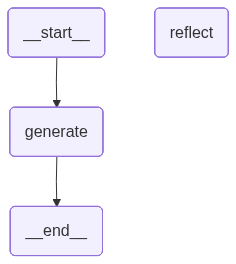

In [29]:
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

## Running the App

In [31]:
inputs = HumanMessage(content='Generate a tweet about FIFA World Cup 26')
response = graph.invoke(inputs)

In [32]:
for resp in response:
  print(resp.content)
  print('\n' + '-' * 100 + '\n')

Generate a tweet about FIFA World Cup 26

----------------------------------------------------------------------------------------------------

🌍⚽️ The countdown to #FIFAWorldCup26 has officially begun! 🥳 Get ready for the greatest showdown on Earth as nations collide and dreams are born! Which team are you rooting for? 🇺🇸🇨🇦🇲🇽 Let the excitement begin! 🎉🏆 #FootballFever #RoadTo2026

----------------------------------------------------------------------------------------------------

Your tweet captures the excitement surrounding the FIFA World Cup 2026 beautifully! The emojis effectively enhance the visual appeal, and your call to action invites engagement from your audience. However, to elevate the depth and impact of your message, consider the following suggestions:

1. **Add a Personal Touch**: Share a brief personal anecdote or a fact about what the World Cup means to you or the significance of this year's tournament. This helps to connect on a deeper level with your followers.

2.